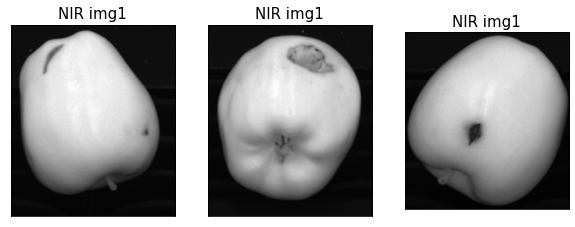

In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import heapq
import pandas as pd
import matplotlib.cm as cm
import scipy.io as sio
import random
%matplotlib inline

img1_gray = cv.imread("computer-vision-fruit-detection/fruit-inspection-images/first task/C0_000001.png", cv.IMREAD_GRAYSCALE)
img2_gray = cv.imread("computer-vision-fruit-detection/fruit-inspection-images/first task/C0_000002.png", cv.IMREAD_GRAYSCALE)
img3_gray = cv.imread("computer-vision-fruit-detection/fruit-inspection-images/first task/C0_000003.png", cv.IMREAD_GRAYSCALE)

img1_color = cv.cvtColor(cv.imread("computer-vision-fruit-detection/fruit-inspection-images/first task/C1_000001.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img2_color = cv.cvtColor(cv.imread("computer-vision-fruit-detection/fruit-inspection-images/first task/C1_000002.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img3_color = cv.cvtColor(cv.imread("computer-vision-fruit-detection/fruit-inspection-images/first task/C1_000003.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB)

# Plot images

def show_img( img_list):
    plt.figure(figsize=(10,10))
    for i in range(len(img_list)):
        plt.subplot(2,3,i+1)
        plt.imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
        plt.title("NIR img1", fontsize = 15)
        plt.xticks([]), plt.yticks([])
    plt.show()

show_img([img1_gray, img2_gray, img3_gray])


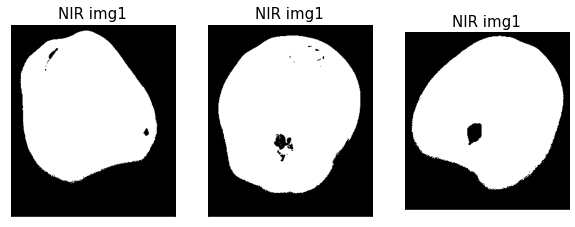

In [7]:
ret1, otsu_img1 = cv.threshold(img1_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
ret2, otsu_img2 = cv.threshold(img2_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
ret3, otsu_img3 = cv.threshold(img3_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

show_img([otsu_img1, otsu_img2, otsu_img3])


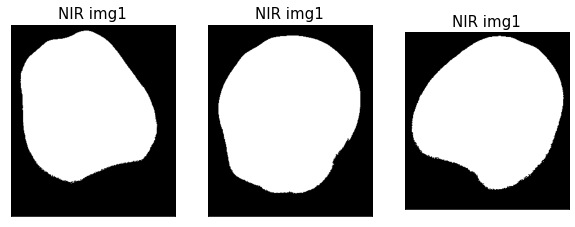

In [8]:
def flood_fill(tr_img):
    im_floodfill = tr_img.copy()
    h, w = tr_img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0,0), 255);
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    im_out = tr_img | im_floodfill_inv
    return im_out

def convert_mask_to_RGB(mask):
    return cv.cvtColor(mask, cv.COLOR_GRAY2BGR)

def apply_mask(mask, rgb_img):
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j, 0] == 0:
                rgb_img[i, j, 0] = 0
                rgb_img[i, j, 1] = 0
                rgb_img[i, j, 2] = 0
    return rgb_img

def remove_edges(img_gray, original_color_img_with_mask, mask):
    th, _ = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)
    canny = cv.Canny(original_color_img_with_mask, th / 2, th)
    #Erosion
    kernel = np.ones((17, 17), np.uint8) 
    eroded_mask = cv.erode(mask, kernel, iterations = 2)
    img_without_edges = canny.copy()
    for i in range(eroded_mask.shape[0]):
        for j in range(eroded_mask.shape[1]):
            if eroded_mask[i, j] == 0:
                img_without_edges[i, j] = 0
    return img_without_edges

def closing(image_without_edges):
    kernel = np.ones((15,15),np.uint8)
    closing = cv.morphologyEx(image_without_edges, cv.MORPH_CLOSE, kernel)
    return closing

def draw_defects(closed_img, img_color):
    contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = 0
    if len(perimeters) > 3:
        # take two most bigger defects
        two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    else:
        # take only the biggest defect
        two_biggest_numbers = heapq.nlargest(1, perimeters)[0]
    for i in range(len(perimeters)):
        if perimeters[i] >= two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=3)

    return img_color


mask1 = flood_fill(otsu_img1)
mask2 = flood_fill(otsu_img2)
mask3 = flood_fill(otsu_img3)


show_img([mask1, mask2, mask3])


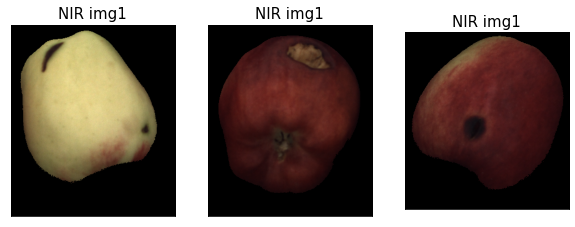

In [9]:
rgb_mask1 = convert_mask_to_RGB(mask1)
rgb_mask2 = convert_mask_to_RGB(mask2)
rgb_mask3 = convert_mask_to_RGB(mask3)

original_color_img_with_mask1 = apply_mask(rgb_mask1, img1_color)
original_color_img_with_mask2 = apply_mask(rgb_mask2, img2_color)
original_color_img_with_mask3 = apply_mask(rgb_mask3, img3_color)

show_img([original_color_img_with_mask1, original_color_img_with_mask2, original_color_img_with_mask3])

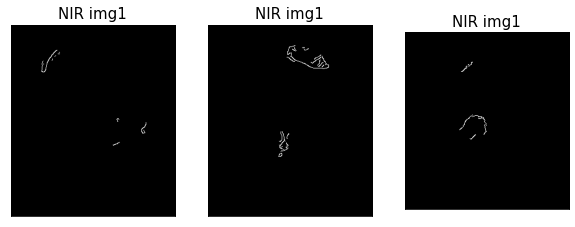

In [10]:
def remove_borders(img_gray, original_color_img_with_mask, mask):
    th, _ = cv.threshold(img_gray, 0, 255, cv.THRESH_OTSU)
    canny = cv.Canny(original_color_img_with_mask, th / 2, th)
    # erosion
    kernel = np.ones((17, 17), np.uint8) 
    eroded_mask = cv.erode(mask, kernel, iterations = 2)
    img_without_edges = canny.copy()
    # apply eroded mask
    for i in range(eroded_mask.shape[0]):
        for j in range(eroded_mask.shape[1]):
            if eroded_mask[i, j] == 0:
                img_without_edges[i, j] = 0
    return img_without_edges

def closing(image_without_edges):
    kernel = np.ones((15,15),np.uint8)
    closing = cv.morphologyEx(image_without_edges, cv.MORPH_CLOSE, kernel)
    return closing

def draw_defects(closed_img, img_color):
    contours, hierarchy = cv.findContours(closed_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = 0
    if len(perimeters) > 3:
        # take two most bigger defects
        two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    else:
        # take only the biggest defect
        two_biggest_numbers = heapq.nlargest(1, perimeters)[0]
    for i in range(len(perimeters)):
        if perimeters[i] >= two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=3)

    return img_color

image_without_edges1 = remove_borders(img1_gray, original_color_img_with_mask1, mask1)
image_without_edges2 = remove_borders(img2_gray, original_color_img_with_mask2, mask2)
image_without_edges3 = remove_borders(img3_gray, original_color_img_with_mask3, mask3)

show_img([image_without_edges1, image_without_edges2, image_without_edges3])

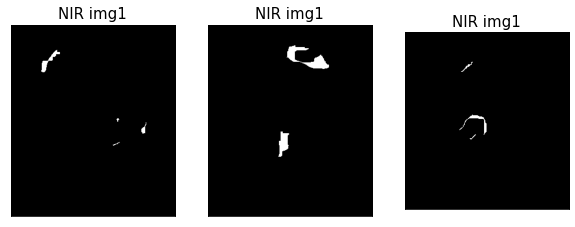

In [11]:

closed_img1 = closing(image_without_edges1)
closed_img2 = closing(image_without_edges2)
closed_img3 = closing(image_without_edges3)

show_img([closed_img1, closed_img2, closed_img3])

In [13]:
def draw_defects(closed_img, img_color):
    contours, hierarchy  = cv.findContours(closed_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = 0
    if len(perimeters) > 3:
        # take two most bigger defects
        two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    else:
        # take only the biggest defect
        two_biggest_numbers = heapq.nlargest(1, perimeters)[0]
    for i in range(len(perimeters)):
        if perimeters[i] >= two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=3)

    return img_color




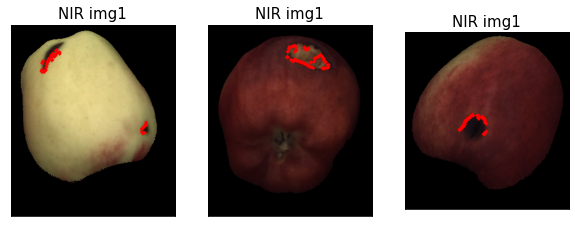

In [14]:
out1 = draw_defects(closed_img1, img1_color)
out2 = draw_defects(closed_img2, img2_color)
out3 = draw_defects(closed_img3, img3_color)

show_img([out1, out2, out3])



In [15]:
#second task

img4_color = cv.cvtColor(cv.imread("computer-vision-fruit-detection/fruit-inspection-images/second task/C1_000004.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img5_color = cv.cvtColor(cv.imread("computer-vision-fruit-detection/fruit-inspection-images/second task/C1_000005.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB)

In [16]:
def generate_hsv_mask(img_color):
    img_hsv = cv.cvtColor(img_color, cv.COLOR_BGR2HSV)
    mask = cv.inRange(img_hsv, (99,50,20), (104,255,255))
    res = cv.bitwise_and(img_color,img_color, mask=mask)
    return res

def findClosestCentroids(X, centroids):
    idx = np.zeros((X.shape[0], 1))
    for p in range(X.shape[0]):
        idx[p] = np.argmin(np.linalg.norm(X[p, :] - centroids, axis=1))
    return idx + 1

def computeCentroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i, :] = np.mean(X[(idx == (i+1)).nonzero()[0], :], axis=0)
    return centroids

def plotDataPoints(X, idx, K):
    colors = cm.rainbow(np.linspace(0, 1, 100))
    for k in range(1, K + 1):
        plt.scatter(X[(idx == (k)).nonzero()[0], 0], X[(idx == (k)).nonzero()[0], 1], s = 5, color=colors[random.randint(0, 99)])
    
def kMeansInitCentroids(X, K):
    X = np.random.permutation(X)
    return X[:K, :]
     
        
def runkMeans(X, initial_centroids, max_iters, plot_clusters_and_centroids = False):
    m = X.shape[0]
    n = X.shape[1]
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros((m, 1))
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)       
        centroids = computeCentroids(X, idx, K)
        if plot_clusters_and_centroids == True:
            plotDataPoints(X, idx, K)
    if plot_clusters_and_centroids == True:
        plt.scatter(centroids[:, 0], centroids[:, 1], linewidths=3, s = 40, c = 'black', marker='x')
    return centroids, idx


def run_kmeans_on_img(img): 
    # Divide by 255 so that all values are in the range 0 - 1
    img = img / 255
    img_size = img.shape

    # Reshape the image into an Nx3 matrix where N = number of pixels.
    # Each row will contain the Red, Green and Blue pixel values
    # This gives us our dataset matrix X that we will use K-Means on
    X = img.reshape((img_size[0] * img_size[1], img_size[2]))
    K = 3
    max_iters = 12

    # When using K-Means, it is important the initialize the centroids randomly
    initial_centroids = kMeansInitCentroids(X, K)

    # running K-means
    centroids, idx = runkMeans(X, initial_centroids, max_iters,plot_clusters_and_centroids=False)

    img_compressed = np.zeros((X.shape[0], X.shape[1]))

    # We can now recover the image from the indices (idx) by mapping each pixel
    # (specified by it's index in idx) to the centroid value
    for i, cluster in enumerate(idx):
        img_compressed[i,:] = centroids[int(cluster[0]) - 1,:]

    # Reshape the recovered image into proper dimensions
    img_compressed = img_compressed.reshape((img_size[0], img_size[1], img_size[2]))
    # revert from [0, 1] range to [0, 255]
    img_compressed = (img_compressed*255).astype(np.uint8)
    return img_compressed

def negative_img(img):
    return 255 - img

def draw_russet_kmeans(neg_img, img_color):
    contours, hierarchy = cv.findContours(neg_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    perimeters = []
    for i in range(len(contours)):
        perimeters.append(len(contours[i]))
    two_biggest_numbers = heapq.nlargest(2, perimeters)[1]
    for i in range(len(perimeters)):
        if perimeters[i] == two_biggest_numbers:
            for j in range(len(contours[i])):
                # draw contour
                img_color = cv.circle(img_color, center=(contours[i][j][0][0], contours[i][j][0][1]), radius=1, color=(255, 0, 0) , thickness=12)

    return img_color

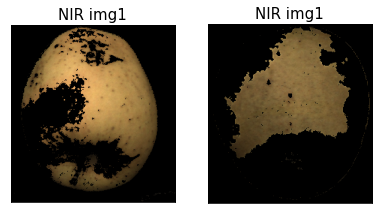

In [17]:

hsv_mask4 = generate_hsv_mask(img4_color)
hsv_mask5 = generate_hsv_mask(img5_color)

show_img([hsv_mask4,hsv_mask5])

In [18]:
mask4 = cv.cvtColor(hsv_mask4, cv.COLOR_RGB2GRAY)
kernel = np.ones((5, 5), np.uint8) 
mask4 = cv.erode(mask4, kernel, iterations = 1)

mask5 = cv.cvtColor(hsv_mask5, cv.COLOR_RGB2GRAY)
kernel = np.ones((5, 5), np.uint8) 
mask5 = cv.erode(mask5, kernel, iterations = 1)

In [19]:
def count_white_pixels(mask):
    return len(np.where(mask > 0)[0])
threshold = (count_white_pixels(mask4) + count_white_pixels(mask5))/2

In [20]:
def color_russet(img_color, mask, threshold):
    # convert mask from rgb to grayscale
    mask = cv.cvtColor(mask, cv.COLOR_RGB2GRAY)
    # we erode the HSV mask for removing some noise
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv.erode(mask, kernel, iterations = 1)
    out = img_color.copy()
    if count_white_pixels(mask) < threshold:
        # color with red dots the HSV found region
        for i in range(img_color.shape[0]):
            for j in range(img_color.shape[1]):
                if mask[i, j] > 0:
                    out = cv.circle(out, center=(j, i), radius=1, color=(255, 0, 0) , thickness=1)
    else:
        # apply k means for grouping same colors regions
        img_compressed = run_kmeans_on_img(img4_color)
        # img_compressed is ok, it is the image with the region highlited by k means
        # here below we do some workoround of the img_compressed to fix a bug
        img_gray = cv.cvtColor(img_compressed, cv.COLOR_RGB2GRAY)
        ret1, otsu_img = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        neg_img = negative_img(otsu_img)
        kernel = np.ones((9,9),np.uint8)
        opened_img = cv.morphologyEx(neg_img, cv.MORPH_OPEN, kernel)
        # draw with red dots the k means found region
        out = draw_russet_kmeans(opened_img, img_color.copy())
    return out

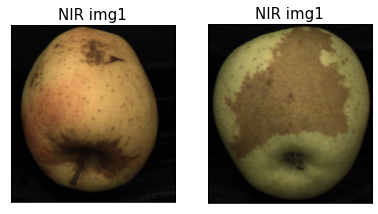

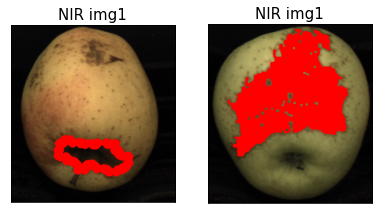

In [24]:
out4 = color_russet(img4_color, hsv_mask4, threshold)
out5 = color_russet(img5_color, hsv_mask5, threshold)

show_img([img4_color, img5_color])
show_img([out4, out5])
